# **Task 1** - Basics

**Baseline**

This pipeline ensures that each image is preprocessed exactly as during training and that folder-based labels are translated to the correct class IDs. The resulting Top-1/Top-5 accuracies establish the reference performance against which all adversarial attacks will be measured.

In [1]:
import os
import json
import torch
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Load pretrained ResNet-34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval().cuda()

# Define ImageNet normalization
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load dataset
dataset_path = "/content/drive/MyDrive/DL Project 3/TestDataSet/TestDataSet"
test_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

# Load official ImageNet class index: maps index → [WNID, label]
with open("/content/drive/MyDrive/DL Project 3/TestDataSet/TestDataSet/imagenet_class_index.json", "r") as f:
    idx_to_info = json.load(f)

# Build WNID → label mapping
wnid_to_label = {v[0]: v[1] for k, v in idx_to_info.items()}

# Load custom label mapping: label → correct ImageNet index
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    label_lines = json.load(f)

label_to_idx = {}
for line in label_lines:
    idx_str, label = line.split(":")
    norm_label = label.strip().replace(" ", "_")
    label_to_idx[norm_label] = int(idx_str.strip())

# Build WNID → correct ImageNet index mapping
wnid_to_correct_idx = {}
for wnid, label in wnid_to_label.items():
    if label in label_to_idx:
        wnid_to_correct_idx[wnid] = label_to_idx[label]

# Rebuild sample list manually with corrected labels
new_samples = []
for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue
    if folder in wnid_to_correct_idx:
        correct_label = wnid_to_correct_idx[folder]
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(".jpeg"):
                img_path = os.path.join(folder_path, fname)
                new_samples.append((img_path, correct_label))

test_dataset.samples = new_samples

# Prepare DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation
def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)

            top1_correct += (top5[:, 0] == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)

    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    return top1_acc, top5_acc

# Run evaluation
top1, top5 = evaluate(model, test_loader)
print(f"\n[Base Line]Top-1 Accuracy: {top1:.2f}%")
print(f"[Base Line]Top-5 Accuracy: {top5:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]
100%|██████████| 32/32 [06:31<00:00, 12.24s/it]


[Base Line]Top-1 Accuracy: 76.00%
[Base Line]Top-5 Accuracy: 94.20%


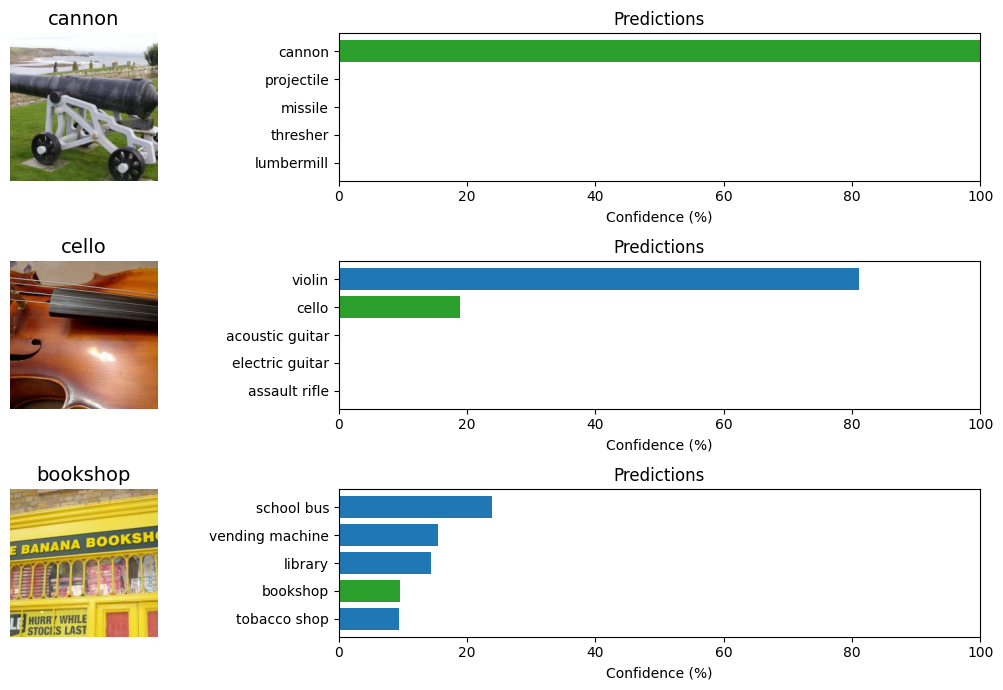

In [2]:
full_label_names = {int(k): v[1].replace('_', ' ')
                    for k, v in idx_to_info.items()}

def unnormalize(img_t):
    img = img_t.cpu().permute(1, 2, 0).numpy()
    img = (img * np.array(std_norms)[None, None, :]) + np.array(mean_norms)[None, None, :]
    return np.clip(img, 0, 1)

import matplotlib.pyplot as plt, numpy as np, random, torch

def plot_three_examples(model, dataset, k=5):
    model_dev = next(model.parameters()).device

    idxs = random.sample(range(len(dataset)), 3)
    imgs  = torch.stack([dataset[i][0] for i in idxs]).to(model_dev)
    gtlbl = torch.tensor([dataset[i][1] for i in idxs])

    with torch.no_grad():
        logits = model(imgs)
        probs  = torch.softmax(logits, dim=-1).cpu()

    fig, axes = plt.subplots(3, 2, figsize=(11, 7),
                             gridspec_kw={'width_ratios': [1, 2]})

    for row in range(3):
        img      = unnormalize(imgs[row])
        gt       = gtlbl[row].item()
        top_vals, top_idx = probs[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        axes[row, 0].imshow(img);     axes[row, 0].axis('off')
        axes[row, 0].set_title(full_label_names.get(gt, str(gt)), fontsize=14)

        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        axes[row, 1].barh(np.arange(k), top_vals, color=colors)
        axes[row, 1].set_yticks(np.arange(k))
        axes[row, 1].set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        axes[row, 1].invert_yaxis();  axes[row, 1].set_xlim(0, 100)
        axes[row, 1].set_xlabel('Confidence (%)'); axes[row, 1].set_title('Predictions')

    plt.tight_layout(); plt.show()

plot_three_examples(model, test_dataset, k=5)

# **Task 2** - Pixelwise Attack


**FGSM**

Here we are implementing the Fast Gradient Sign Method (FGSM) to generate one-step adversarial examples against our pretrained ResNet-34 model, saves those perturbed images to disk, and then evaluates the model on them. First, we define fgsm_attack() to compute the gradient of the classification loss with respect to the input, take its sign, and perturb the original image by a small amount ε in that direction. We then loop over each batch in test_loader, move the images and labels to the GPU, and call fgsm_attack() to produce adversarial versions. For each perturbed image, we record its tensor and original label, undo the normalization so we can save it as a human-viewable PNG, and write it into Adversarial Test Set 1 with a filename encoding the batch and index. After processing the entire test set, we stack all adversarial tensors into a new TensorDataset, wrap it in a DataLoader, and run our standard evaluate() function to compute Top-1 and Top-5 accuracy on the adversarial data, printing out the dramatic accuracy drop that demonstrates the model’s vulnerability to FGSM.

In [3]:
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# FGSM attack: one‐step perturbation in the direction of the gradient’s sign
def fgsm_attack(image, label, model, epsilon=0.02):
    # Enable gradient tracking on the input image
    image.requires_grad = True

    # Forward pass
    output = model(image)
    # Compute classification loss
    loss = F.cross_entropy(output, label)

    # Zero out any existing gradients, then backpropagate
    model.zero_grad()
    loss.backward()

    # Collect the sign of the gradient on the image
    grad_sign = image.grad.data.sign()
    # Create adversarial image by adjusting pixels by epsilon in gradient direction
    adv_image = image + epsilon * grad_sign
    return adv_image

# Directory to save adversarial examples
adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1"
os.makedirs(adv_dir, exist_ok=True)

# Lists to store adversarial tensors and labels for later evaluation
adv_samples = []
original_labels = []
adv_labels = []

# Ensure model is in evaluation mode and moved to GPU
model.eval().cuda()

# Iterate over the clean test dataloader
for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
    # Move data to GPU
    images, labels = images.cuda(), labels.cuda()

    # Generate adversarial examples for the entire batch
    adv_images = fgsm_attack(images, labels, model)

    # Process each image individually for saving and recording
    for i in range(images.size(0)):
        img = adv_images[i]
        lbl = labels[i].item()

        # Model prediction on the adversarial image
        output = model(img.unsqueeze(0))
        pred = output.argmax(1).item()

        # Record adversarial tensor and labels
        adv_samples.append(img.cpu())
        original_labels.append(lbl)
        adv_labels.append(pred)

        # Undo normalization for visualization/saving
        unnorm = (
            img * torch.tensor(std_norms, device=img.device).view(3, 1, 1) +
            torch.tensor(mean_norms, device=img.device).view(3, 1, 1)
        )
        # Save the unnormalized adversarial image as PNG
        save_image(unnorm, os.path.join(adv_dir, f"{batch_idx}_{i}_adv.png"))

# Build a new TensorDataset from the collected adversarial tensors and original labels
from torch.utils.data import TensorDataset, DataLoader

adv_tensor = torch.stack(adv_samples)
adv_targets = torch.tensor(original_labels)
adv_dataset = TensorDataset(adv_tensor, adv_targets)
adv_loader = DataLoader(adv_dataset, batch_size=16)

# Evaluate the model on the adversarial dataset
top1, top5 = evaluate(model, adv_loader)
print(f"\n[FGSM] Top-1 Accuracy: {top1:.2f}%")
print(f"[FGSM] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:00<00:00, 91.41it/s]


[FGSM] Top-1 Accuracy: 6.20%
[FGSM] Top-5 Accuracy: 35.60%


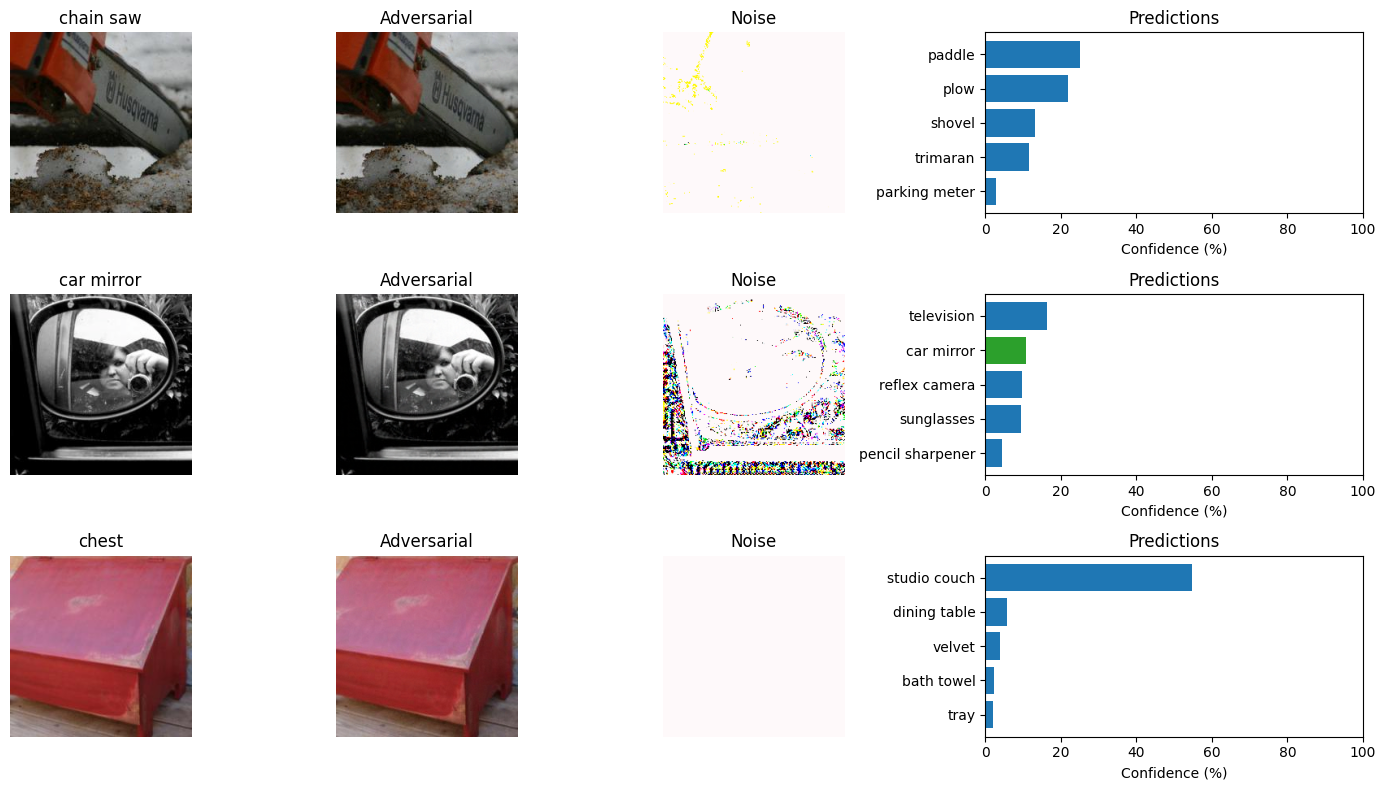

In [4]:
import torch, numpy as np, matplotlib.pyplot as plt, random

def plot_three_fgsm_examples(model,
                             dataset,
                             epsilon   = 0.02,
                             k         = 5,
                             idx_list  = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    imgs, gtlbls, adv_imgs, probs_list = [], [], [], []

    for idx in idx_list:
        img_t, gt_lbl = dataset[idx]
        img_t  = img_t.unsqueeze(0).to(model_dev)
        gt_lbl = torch.tensor([gt_lbl]).to(model_dev)

        adv_t = fgsm_attack(img_t.clone(), gt_lbl, model, epsilon)

        with torch.no_grad():
            adv_prob = torch.softmax(model(adv_t), dim=-1)[0].cpu()

        imgs.append(img_t[0].detach())
        adv_imgs.append(adv_t[0].detach())
        gtlbls.append(gt_lbl.item())
        probs_list.append(adv_prob)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(imgs[row])
        adv_disp   = unnormalize(adv_imgs[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im); ax.axis('off'); ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_fgsm_examples(model, test_dataset, epsilon=0.02, k=5)


**Task 3**

# **Task 3** - Improved Attacks


**I-FGSM**

In this we are implementing the Iterative Fast Gradient Sign Method (I-FGSM) to craft stronger adversarial examples and then measures ResNet-34’s performance on them. First, the ifgsm_attack() function clones each input batch, enables gradient tracking, and then, over a fixed number of steps, repeatedly computes the cross-entropy loss, backpropagates to obtain the input gradient, and takes a small step (α) in its sign. After each update, the perturbation is clipped to lie within an L∞-ball of radius ε around the original image. Once all iterations are complete, the final adversarial tensors are detached from the gradient graph. The main loop applies this attack to every batch from test_loader, records both the original labels and the model’s adversarial predictions, and saves each un‐normalized perturbed image to disk. Finally, all adversarial tensors and true labels are stacked into a new TensorDataset and passed through the evaluate() routine to report the Top-1 and Top-5 accuracies on the I-FGSM attack set.

In [5]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def ifgsm_attack(image, label, model, eps=0.02, alpha=0.005, steps=60):
    """
    Performs the Iterative FGSM (I-FGSM) attack on a batch of images.

    Args:
        image (Tensor): input batch of images, normalized, shape (B, C, H, W)
        label (Tensor): true labels for the batch, shape (B,)
        model (nn.Module): the target model (in eval mode)
        eps (float): total maximum perturbation (L_infinity norm)
        alpha (float): step size per iteration
        steps (int): number of attack iterations

    Returns:
        Tensor: adversarially perturbed images, same shape as `image`
    """
    # Keep a fixed reference to the original images (no grad)
    orig = image.detach()
    # Initialize adversarial images as a copy of the originals, enable grad
    adv = orig.clone().detach().requires_grad_(True)

    for _ in range(steps):
        # Forward pass on the current adversarial images
        output = model(adv)
        # Compute standard cross-entropy loss against the true labels
        loss = F.cross_entropy(output, label)

        # Zero out any existing gradients in model and adv
        model.zero_grad()
        adv.grad = None

        # Backpropagate to compute gradient of loss w.r.t. the input images
        loss.backward()

        # Take a step in the direction of the sign of the gradient
        adv.data += alpha * adv.grad.sign()

        # Project the perturbation back into the L_infinity ball of radius eps
        perturb = torch.clamp(adv - orig, min=-eps, max=eps)
        adv.data = orig + perturb

    # Return the final adversarial examples without gradient tracking
    return adv.detach()


# Directory to store I-FGSM adversarial images
adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1 (I-FGSM)"
os.makedirs(adv_dir, exist_ok=True)

# Lists to accumulate adversarial samples and labels for evaluation
adv_samples, original_labels, adv_labels = [], [], []

# Ensure model is in eval mode and on GPU
model.eval().cuda()

# Generate adversarial dataset
for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="I-FGSM batches")):
    # Move data to GPU
    images, labels = images.cuda(), labels.cuda()

    # Craft adversarial perturbations for the whole batch
    adv_images = ifgsm_attack(images, labels, model)

    # Iterate over each sample in the batch to save and record
    for i in range(images.size(0)):
        img = adv_images[i]            # adversarial image tensor
        lbl = labels[i].item()         # original true label
        # Model's prediction on the adversarial image
        pred = model(img.unsqueeze(0)).argmax(1).item()

        # Store for later bulk evaluation
        adv_samples.append(img.cpu())
        original_labels.append(lbl)
        adv_labels.append(pred)

        # Undo normalization for saving to disk (map back to [0,1])
        unnorm = (
            img * torch.tensor(std_norms, device=img.device).view(3,1,1)
            + torch.tensor(mean_norms, device=img.device).view(3,1,1)
        )
        # Save the unnormalized adversarial image as PNG
        save_image(unnorm, os.path.join(adv_dir, f"{batch_idx}_{i}_ifgsm.png"))

# Create a TensorDataset from all adversarial samples and their true labels
adv_tensor = torch.stack(adv_samples)
adv_targets = torch.tensor(original_labels)
adv_dataset = TensorDataset(adv_tensor, adv_targets)
adv_loader  = DataLoader(adv_dataset, batch_size=16)

# Evaluate model performance on the I-FGSM adversarial set
top1, top5 = evaluate(model, adv_loader)
print(f"\n[I-FGSM] Top-1 Accuracy: {top1:.2f}%")
print(f"[I-FGSM] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:00<00:00, 92.28it/s]


[I-FGSM] Top-1 Accuracy: 0.00%
[I-FGSM] Top-5 Accuracy: 6.20%


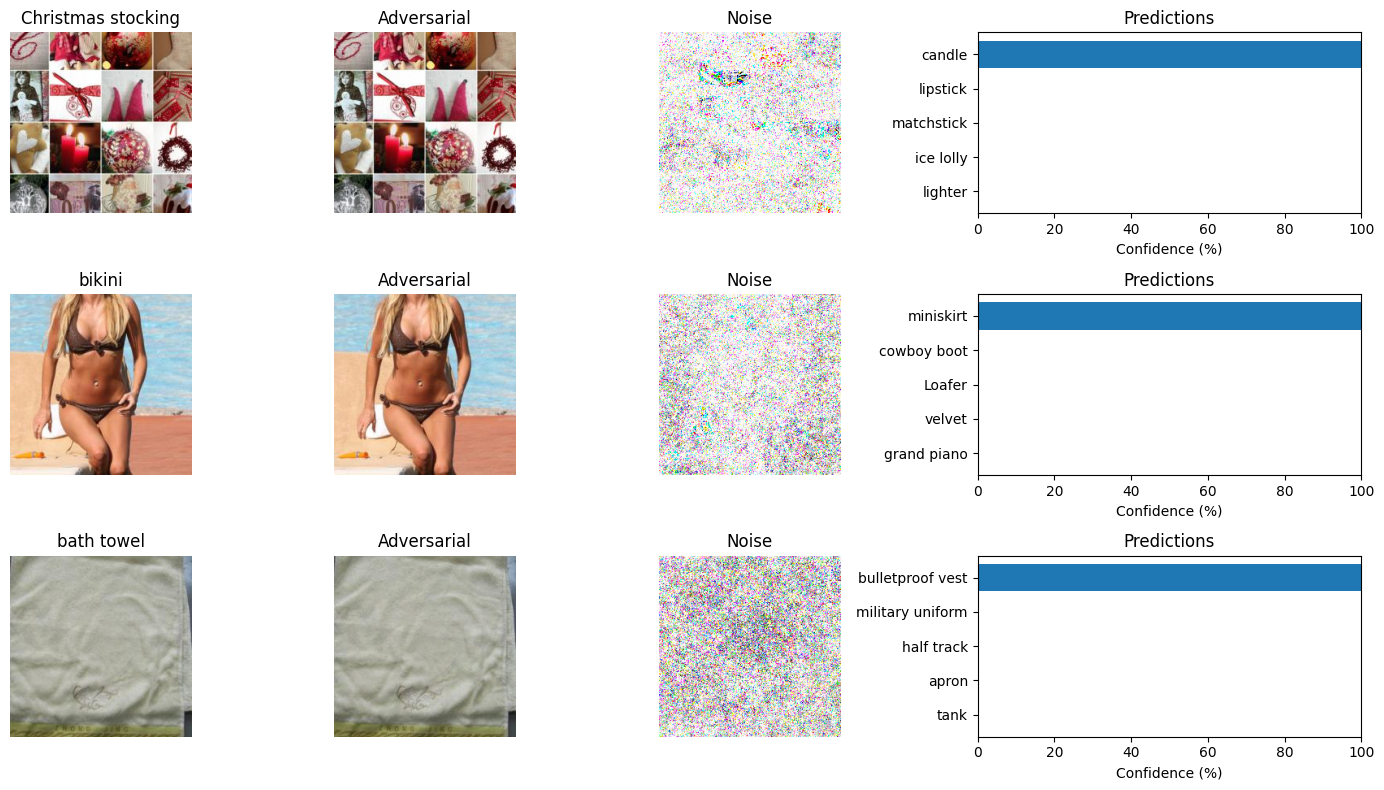

In [6]:
import torch, numpy as np, matplotlib.pyplot as plt, random

def plot_three_ifgsm_examples(model,
                              dataset,
                              eps        = 0.02,
                              alpha      = 0.005,
                              steps      = 60,
                              k          = 5,
                              idx_list   = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    imgs, adv_imgs, gtlbls, probs_list = [], [], [], []

    for idx in idx_list:
        img_t, gt_lbl = dataset[idx]
        img_t  = img_t.unsqueeze(0).to(model_dev)
        gt_lbl = torch.tensor([gt_lbl]).to(model_dev)

        adv_t = ifgsm_attack(img_t.clone(), gt_lbl, model,
                             eps=eps, alpha=alpha, steps=steps)

        with torch.no_grad():
            adv_prob = torch.softmax(model(adv_t), dim=-1)[0].cpu()

        imgs.append(img_t[0].detach())
        adv_imgs.append(adv_t[0].detach())
        gtlbls.append(gt_lbl.item())
        probs_list.append(adv_prob)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(imgs[row])
        adv_disp   = unnormalize(adv_imgs[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_ifgsm_examples(model, test_dataset)

**MI-FGSM**

In this we are implementing the Momentum‐Iterative FGSM (MI‐FGSM) attack and measures ResNet-34’s robustness to it. First, the helper function mifgsm_attack() takes a batch of normalized images and their labels, makes a detached copy of the originals, and initializes a zero‐filled momentum buffer. Over a fixed number of iterations, it computes the cross‐entropy loss on the current adversarial batch, backpropagates to obtain the gradient w.r.t. the inputs, normalizes that gradient by its mean absolute value, and updates the momentum term via an exponential moving average. Each step then perturbs the images by a small step size in the sign of this momentum buffer, and the cumulative perturbation is projected back into the allowed L∞ ball of radius ε around the original images. After crafting the full set of adversarial examples, the code loops over every sample to undo normalization for human‐viewable PNG saving, records both the perturbed tensors and their original labels, and stacks them into a new TensorDataset. Finally, it wraps that in a DataLoader and invokes the standard evaluate() routine to report Top-1 and Top-5 accuracy on the MI-FGSM adversarial set.

In [7]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def mifgsm_attack(image, label, model, eps=0.02, alpha=0.005, steps=60, mu=0.5):
    """
    Performs the Momentum Iterative FGSM (MI-FGSM) attack on a batch of images.

    Args:
        image (Tensor): input batch of images, shape (B, C, H, W)
        label (Tensor): true labels for the batch, shape (B,)
        model (nn.Module): the target model (in eval mode)
        eps (float): L∞ perturbation bound
        alpha (float): step size per iteration
        steps (int): number of attack iterations
        mu (float): momentum decay factor

    Returns:
        Tensor: adversarially perturbed images, same shape as `image`
    """
    # Detach original images; we keep this for projection
    orig = image.detach()
    # Initialize adversarial images with gradient tracking enabled
    adv = orig.clone().detach().requires_grad_(True)
    # Initialize a momentum buffer of zeros
    momentum = torch.zeros_like(adv)

    for _ in range(steps):
        # Forward pass on current adversarial images
        output = model(adv)
        # Compute loss against true labels
        loss = F.cross_entropy(output, label)
        # Zero existing gradients in model and input
        model.zero_grad()
        adv.grad = None
        # Backpropagate to compute gradient w.r.t. images
        loss.backward()

        # Normalize the gradient by its mean absolute value over each sample
        grad = adv.grad / (adv.grad.abs().mean(dim=(1,2,3), keepdim=True) + 1e-8)
        # Update the momentum term
        momentum = mu * momentum + grad
        # Take a step in the sign of the momentum
        adv.data += alpha * momentum.sign()

        # Project the perturbation back into the L∞ ε-ball around original
        perturb = torch.clamp(adv - orig, min=-eps, max=eps)
        adv.data = orig + perturb

    # Return final adversarial examples without gradient tracking
    return adv.detach()


# Directory to save MI-FGSM adversarial images
adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1 (MI-FGSM)"
os.makedirs(adv_dir, exist_ok=True)

# Lists to collect adversarial samples and labels
adv_samples, original_labels, adv_labels = [], [], []

# Ensure model is in evaluation mode on GPU
model.eval().cuda()

# Generate and save adversarial examples batch by batch
for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="MI-FGSM batches")):
    # Move data to GPU
    images, labels = images.cuda(), labels.cuda()
    # Craft adversarial images using MI-FGSM
    adv_images = mifgsm_attack(images, labels, model)

    # Iterate through the batch to record and save
    for i in range(images.size(0)):
        img = adv_images[i]                       # adversarial image tensor
        lbl = labels[i].item()                    # true label
        # Model’s prediction on the adversarial image
        pred = model(img.unsqueeze(0)).argmax(1).item()

        # Append to lists for bulk evaluation later
        adv_samples.append(img.cpu())
        original_labels.append(lbl)
        adv_labels.append(pred)

        # Undo normalization for visualization (map back to [0,1])
        unnorm = (
            img * torch.tensor(std_norms, device=img.device).view(3, 1, 1)
            + torch.tensor(mean_norms, device=img.device).view(3, 1, 1)
        )
        # Save the unnormalized adversarial image
        save_image(unnorm, os.path.join(adv_dir, f"{batch_idx}_{i}_mifgsm.png"))

# Build a TensorDataset and DataLoader for evaluation
adv_tensor = torch.stack(adv_samples)
adv_targets = torch.tensor(original_labels)
adv_dataset = TensorDataset(adv_tensor, adv_targets)
adv_loader  = DataLoader(adv_dataset, batch_size=16)

# Evaluate model performance on the MI-FGSM adversarial set
top1, top5 = evaluate(model, adv_loader)
print(f"\n[MI-FGSM] Top-1 Accuracy: {top1:.2f}%")
print(f"[MI-FGSM] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:00<00:00, 91.45it/s]


[MI-FGSM] Top-1 Accuracy: 0.00%
[MI-FGSM] Top-5 Accuracy: 4.40%


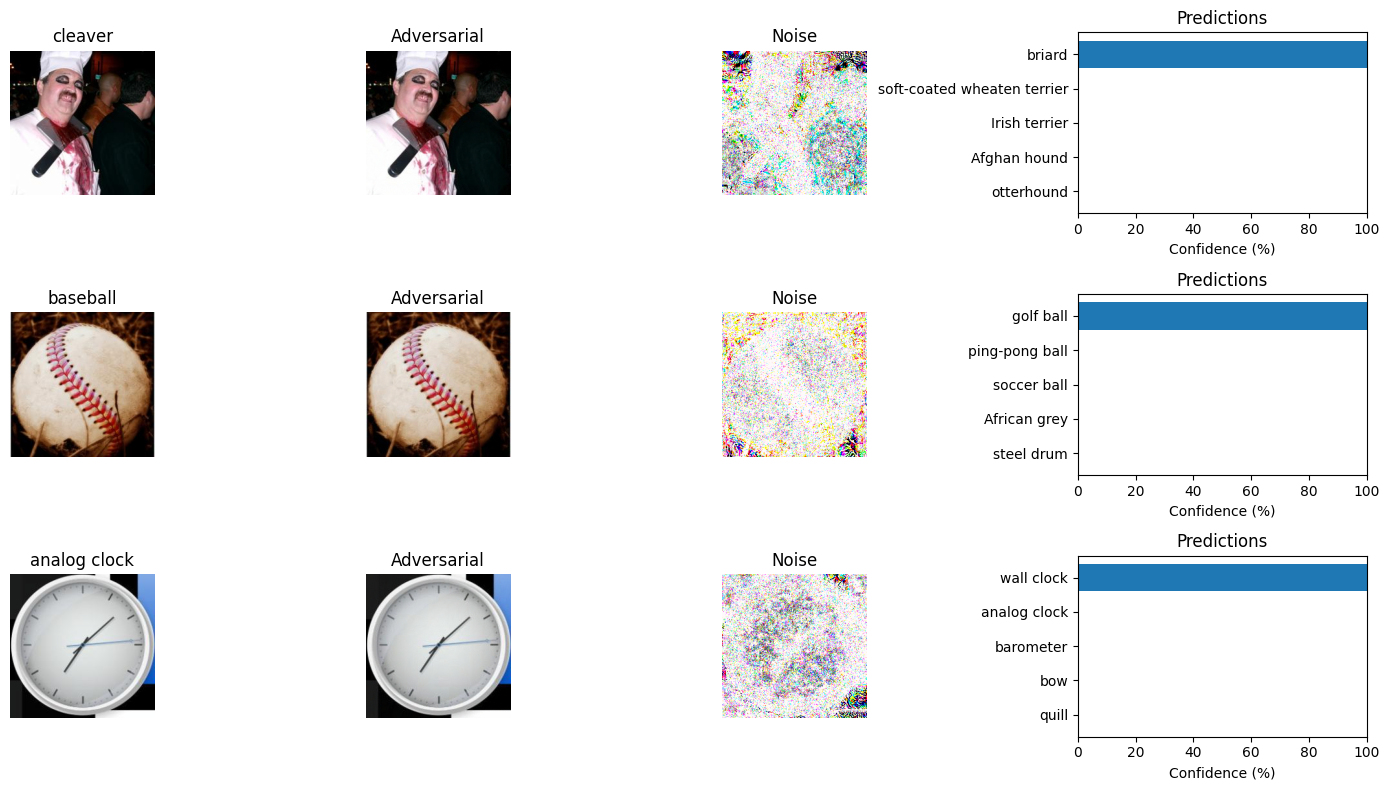

In [8]:
def plot_three_mifgsm_examples(model,
                               dataset,
                               eps      = 0.02,
                               alpha    = 0.005,
                               steps    = 60,
                               mu       = 0.5,
                               k        = 5,
                               idx_list = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    imgs, adv_imgs, gtlbls, probs_list = [], [], [], []

    for idx in idx_list:
        img_t, gt_lbl = dataset[idx]
        img_t  = img_t.unsqueeze(0).to(model_dev)
        gt_lbl = torch.tensor([gt_lbl]).to(model_dev)

        adv_t = mifgsm_attack(img_t.clone(), gt_lbl, model,
                              eps=eps, alpha=alpha, steps=steps, mu=mu)

        with torch.no_grad():
            adv_prob = torch.softmax(model(adv_t), dim=-1)[0].cpu()

        imgs.append(img_t[0].detach())
        adv_imgs.append(adv_t[0].detach())
        gtlbls.append(gt_lbl.item())
        probs_list.append(adv_prob)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(imgs[row])
        adv_disp   = unnormalize(adv_imgs[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im); ax.axis('off'); ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()


plot_three_mifgsm_examples(model, test_dataset)

**PGD**

In this we are implementing a multi‐restart Projected Gradient Descent (PGD) attack and evaluates ResNet-34 on the resulting adversarial set. First, the helper function pgd_attack() takes a batch of normalized images and repeatedly perturbs them in the direction of the loss gradient (step size α), projecting the cumulative perturbation back into an L∞‐ball of radius ε after each update. By optionally initializing each restart with a random noise within that ε‐ball and keeping the adversarial example that maximizes the classification loss, it finds the strongest per‐sample attack over several restarts. In the main loop, we apply this attack to every batch from test_loader, record and save each un‐normalized perturbed image to disk (for visual inspection), and collect all adversarial tensors along with their true labels. Finally, we package these into a new TensorDataset and run our standard evaluate() routine to report the model’s Top-1 and Top-5 accuracy on the PGD attack set, quantifying how effectively this worst‐case, iterative strategy degrades performance.

In [6]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def pgd_attack(image, label, model,
               eps=0.02, alpha=0.005, steps=60,
               random_start=True, restarts=10):
    """
    Performs the multi-restart Projected Gradient Descent (PGD) attack under an L∞ constraint.

    Args:
        image (Tensor): batch of normalized input images, shape (B,C,H,W)
        label (Tensor): true labels for the batch, shape (B,)
        model (nn.Module): target model in eval mode
        eps (float): maximum L∞ perturbation
        alpha (float): step size for each iteration
        steps (int): number of gradient steps per restart
        random_start (bool): whether to begin each restart at a random point in the ε-ball
        restarts (int): number of random-restart runs; keep the worst-case adversarial example

    Returns:
        Tensor: best adversarial examples found over all restarts, shape (B,C,H,W)
    """
    # Keep a copy of the original clean images
    orig = image.detach()
    device = image.device

    # Buffers to track the worst (highest loss) adversarial example per sample
    best_adv  = orig.clone()
    best_loss = torch.full((image.size(0),), -1e9, device=device)

    # Repeat the attack with multiple random restarts
    for _ in range(restarts):
        # Initialize adversarial images: random uniform perturbation within [-eps, +eps] if desired
        if random_start:
            adv = orig + torch.empty_like(orig).uniform_(-eps, eps)
        else:
            adv = orig.clone()
        adv = adv.detach().requires_grad_(True)

        # Perform iterative updates for this restart
        for _ in range(steps):
            # Forward pass and compute per-sample cross-entropy
            logits = model(adv)
            loss   = F.cross_entropy(logits, label)

            # Zero existing gradients
            model.zero_grad()
            adv.grad = None
            # Backpropagate to get gradient w.r.t. the inputs
            loss.backward()

            # Take a step in the sign of the gradient
            adv.data += alpha * adv.grad.sign()
            # Project back into the valid L∞ ball around the original images
            perturb = torch.clamp(adv - orig, min=-eps, max=eps)
            adv.data = orig + perturb

        # After the final step, evaluate loss and keep the worst-case example
        with torch.no_grad():
            final_logits = model(adv)
            final_loss   = F.cross_entropy(final_logits, label, reduction='none')
            # Identify which samples are “more adversarial” (higher loss)
            better = final_loss > best_loss
            # Update buffers for those cases
            best_loss[better] = final_loss[better]
            best_adv [better] = adv[better]

    # Return the adversarial examples corresponding to the highest loss per sample
    return best_adv.detach()


# Directory to save PGD adversarial images
adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 1 (PGD)"
os.makedirs(adv_dir, exist_ok=True)

# Lists to collect adversarial samples and their original labels
adv_samples, orig_labels = [], []

# Ensure the model is in evaluation mode on GPU
model.eval().cuda()

# Generate adversarial examples for each batch and save them
for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="PGD batches")):
    images, labels = images.cuda(), labels.cuda()
    # Craft adversarial images with PGD
    adv_images = pgd_attack(images, labels, model,
                            eps=0.02, alpha=0.005,
                            steps=40, random_start=True,
                            restarts=10)

    # Record adversarial tensors and labels for evaluation
    adv_samples.extend(adv_images.cpu())
    orig_labels.extend(labels.cpu())

    # Save each adversarial image after undoing normalization
    for i in range(images.size(0)):
        unnorm = (
            adv_images[i] * torch.tensor(std_norms, device=adv_images.device).view(3,1,1)
            + torch.tensor(mean_norms, device=adv_images.device).view(3,1,1)
        )
        save_image(unnorm.cpu(), os.path.join(adv_dir, f"{batch_idx}_{i}_pgd.png"))

# Build a new dataset from the collected adversarial examples
adv_tensor   = torch.stack(adv_samples)
adv_dataset  = TensorDataset(adv_tensor, torch.tensor(orig_labels))
adv_loader   = DataLoader(adv_dataset, batch_size=16)

# Evaluate the model on the PGD adversarial set
top1, top5 = evaluate(model, adv_loader)
print(f"\n[PGD] Top-1 Accuracy: {top1:.2f}%")
print(f"[PGD] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:00<00:00, 89.69it/s]


[PGD] Top-1 Accuracy: 0.00%
[PGD] Top-5 Accuracy: 6.20%


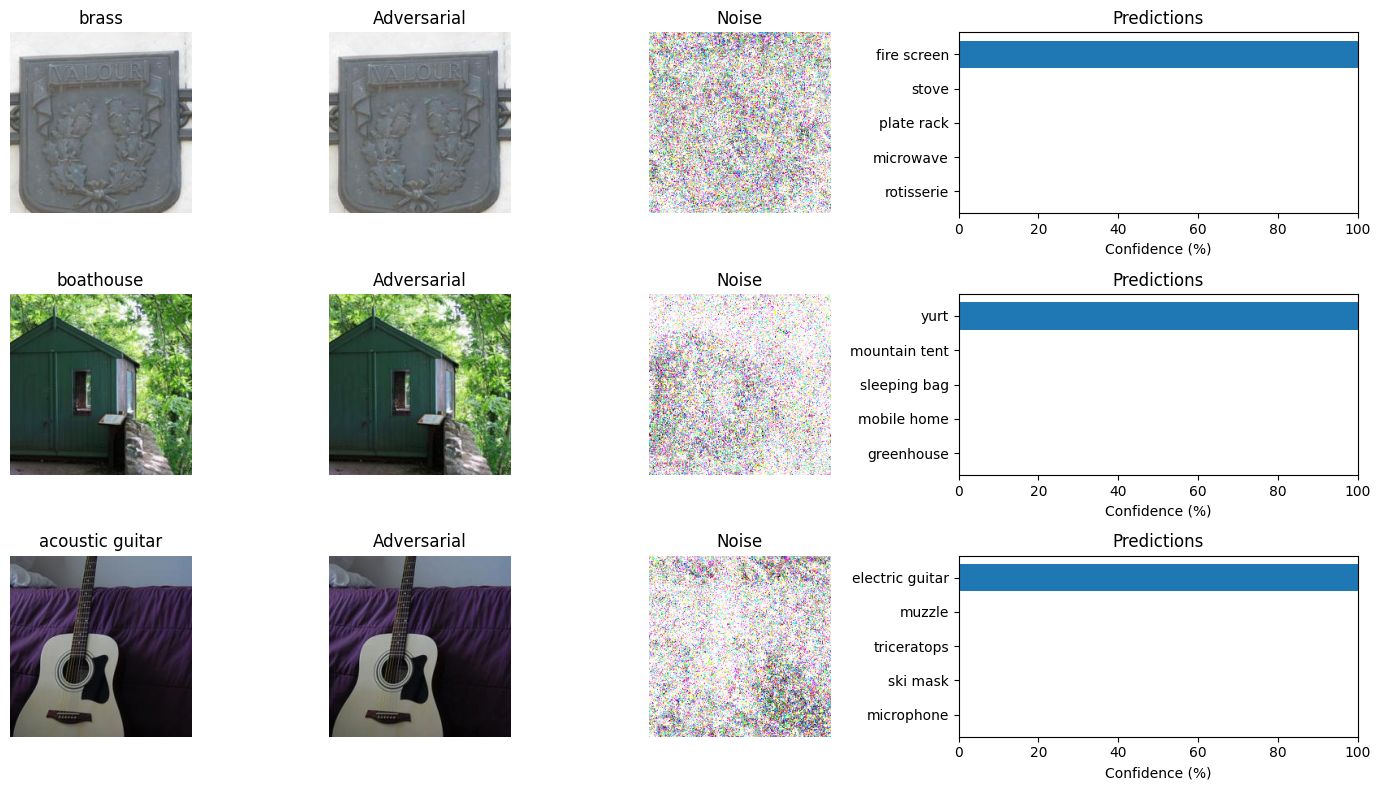

In [7]:
import torch, numpy as np, matplotlib.pyplot as plt, random

def plot_three_pgd_examples(model,
                            dataset,
                            eps        = 0.02,
                            alpha      = 0.005,
                            steps      = 60,
                            restarts   = 10,
                            random_start = True,
                            k          = 5,
                            idx_list   = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    clean_t, adv_t, gtlbls, probs_list = [], [], [], []

    for idx in idx_list:
        img, lbl = dataset[idx]
        img_t  = img.unsqueeze(0).to(model_dev)
        lbl_t  = torch.tensor([lbl]).to(model_dev)

        adv_img = pgd_attack(img_t.clone(), lbl_t, model,
                             eps=eps, alpha=alpha, steps=steps,
                             random_start=random_start, restarts=restarts)

        with torch.no_grad():
            probs = torch.softmax(model(adv_img), dim=-1)[0].cpu()

        clean_t.append(img_t[0].detach())
        adv_t.append(adv_img[0].detach())
        gtlbls.append(lbl)
        probs_list.append(probs)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(clean_t[row])
        adv_disp   = unnormalize(adv_t[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                [full_label_names.get(gt, str(gt)),
                                 'Adversarial',
                                 'Noise']):
            ax = axes[row, col]
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(ttl, fontsize=12)

        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_pgd_examples(model, test_dataset, eps=0.02, alpha=0.005,
                         steps=60, restarts=10)


# **Task 4** - Patch Attack

**Patch PGD with Momentum**

 Here we are implementing a localized PGD attack with Nesterov‐style momentum and multiple random restarts, confined to a 32 × 32 patch per image. First, for each sample in the batch it constructs a binary mask that selects one random patch location. It then repeats the following procedure for a fixed number of restarts: initialize the adversarial image by adding uniform noise within the ε‐ball only inside the mask, and iterate a PGD loop where each step computes a “look‐ahead” perturbation based on the current momentum buffer, backpropagates to get gradients only inside the patch, normalizes them, updates the momentum, and takes an ε‐constrained sign step within the patch. After all iterations, it retains the adversarial example that yields the highest loss. In the main loop it applies this attack to every batch from test_loader, saves each unnormalized adversarial patch image to disk, and accumulates all perturbed tensors along with their true labels. Finally, it packages these into a new dataset and calls evaluate() to report the model’s Top-1 and Top-5 accuracy under the Patch-PGD momentum attack.

In [8]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def patch_pgd_momentum(image, label, model,
                       eps=0.5, alpha=0.08, steps=60,
                       mu=0.5, restarts=10, patch_size=32):
    """
    Performs a localized patch‐based PGD attack with Nesterov momentum.

    Args:
        image (Tensor): batch of normalized images, shape (B,C,H,W)
        label (Tensor): true labels, shape (B,)
        model (nn.Module): target model in eval mode
        eps (float): max L∞ perturbation inside the patch
        alpha (float): step size for each update
        steps (int): number of iterations per restart
        mu (float): momentum decay factor
        restarts (int): number of random restarts to pick worst-case
        patch_size (int): side length of the square patch in pixels

    Returns:
        best_adv (Tensor): adversarial images after patch‐PGD, shape (B,C,H,W)
        coords (list): top‐left coordinates of the patch for each sample
    """
    B, _, H, W = image.size()
    device = image.device

    # Create a binary mask that selects a random patch per image
    mask = torch.zeros_like(image)
    coords = []
    for i in range(B):
        # Randomly choose top‐left corner within valid range
        t = torch.randint(0, H - patch_size + 1, ()).item()
        l = torch.randint(0, W - patch_size + 1, ()).item()
        mask[i, :, t:t+patch_size, l:l+patch_size] = 1
        coords.append((t, l))

    # Keep the original clean images and buffers for best adversarial results
    orig = image.detach()
    best_adv  = orig.clone()
    best_loss = torch.full((B,), -1e9, device=device)

    # Perform multiple random-restart attempts
    for _ in range(restarts):
        # Initialize adversarial images with random noise inside the patch
        noise = torch.empty_like(orig).uniform_(-eps, eps) * mask
        adv = (orig + noise).detach()
        g   = torch.zeros_like(adv)  # momentum buffer

        # Iteratively refine the adversarial patch
        for _ in range(steps):
            # Nesterov look‐ahead step: perturbed by momentum
            look = (adv + alpha * mu * g).detach().requires_grad_(True)
            logits = model(look)
            # Compute per-sample loss without reduction
            loss   = F.cross_entropy(logits, label, reduction='none')
            model.zero_grad()
            look.grad = None
            loss.sum().backward()

            # Normalize gradient and restrict it to the patch region
            grad = look.grad / (look.grad.abs().mean(dim=(1,2,3), keepdim=True) + 1e-8)
            grad = grad * mask
            # Update momentum and take a step in its sign
            g   = mu * g + grad
            adv = adv + alpha * g.sign() * mask

            # Project perturbation back into the ε‐ball inside the patch
            perturb = torch.clamp(adv - orig, min=-eps, max=eps) * mask
            adv     = orig + perturb

        # After iterations, evaluate loss and keep the sample that maximizes it
        with torch.no_grad():
            final_logits = model(adv)
            final_loss   = F.cross_entropy(final_logits, label, reduction='none')
            better = final_loss > best_loss
            best_loss[better] = final_loss[better]
            best_adv [better] = adv[better]

    return best_adv.detach(), coords


# Directory to save Patch-PGD examples
adv_dir = "/content/drive/MyDrive/DL Project 3/Adversarial Test Set 3 (Patch-PGD)"
os.makedirs(adv_dir, exist_ok=True)

# Lists to collect adversarial and original data for evaluation
adv_samples, orig_samples, coords_list = [], [], []
orig_labels, adv_labels = [], []

model.eval().cuda()

# Loop over the clean test DataLoader
for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Patch-PGD batches")):
    images, labels = images.cuda(), labels.cuda()
    # Generate adversarial images and record patch coordinates
    adv_images, coords = patch_pgd_momentum(images, labels, model)
    preds = model(adv_images).argmax(1)

    # Accumulate adversarial and original tensors and labels
    adv_samples.extend(adv_images.cpu())
    orig_samples.extend(images.cpu())
    coords_list.extend(coords)
    orig_labels.extend(labels.cpu())
    adv_labels.extend(preds.cpu())

    # Save each adversarial image (still normalized) to disk
    for i in range(images.size(0)):
        save_image(
            adv_images[i].cpu(),
            os.path.join(adv_dir, f"{batch_idx}_{i}_patchpgd.png")
        )

# Build DataLoader for evaluation
adv_tensor  = torch.stack(adv_samples)
adv_dataset = TensorDataset(adv_tensor, torch.tensor(orig_labels))
adv_loader  = DataLoader(adv_dataset, batch_size=16)

# Evaluate on the Patch-PGD adversarial set
top1, top5 = evaluate(model, adv_loader)
print(f"\n[Patch-PGD] Top-1 Accuracy: {top1:.2f}%")
print(f"[Patch-PGD] Top-5 Accuracy: {top5:.2f}%")

100%|██████████| 32/32 [00:00<00:00, 88.87it/s]


[Patch-PGD] Top-1 Accuracy: 12.00%
[Patch-PGD] Top-5 Accuracy: 58.20%


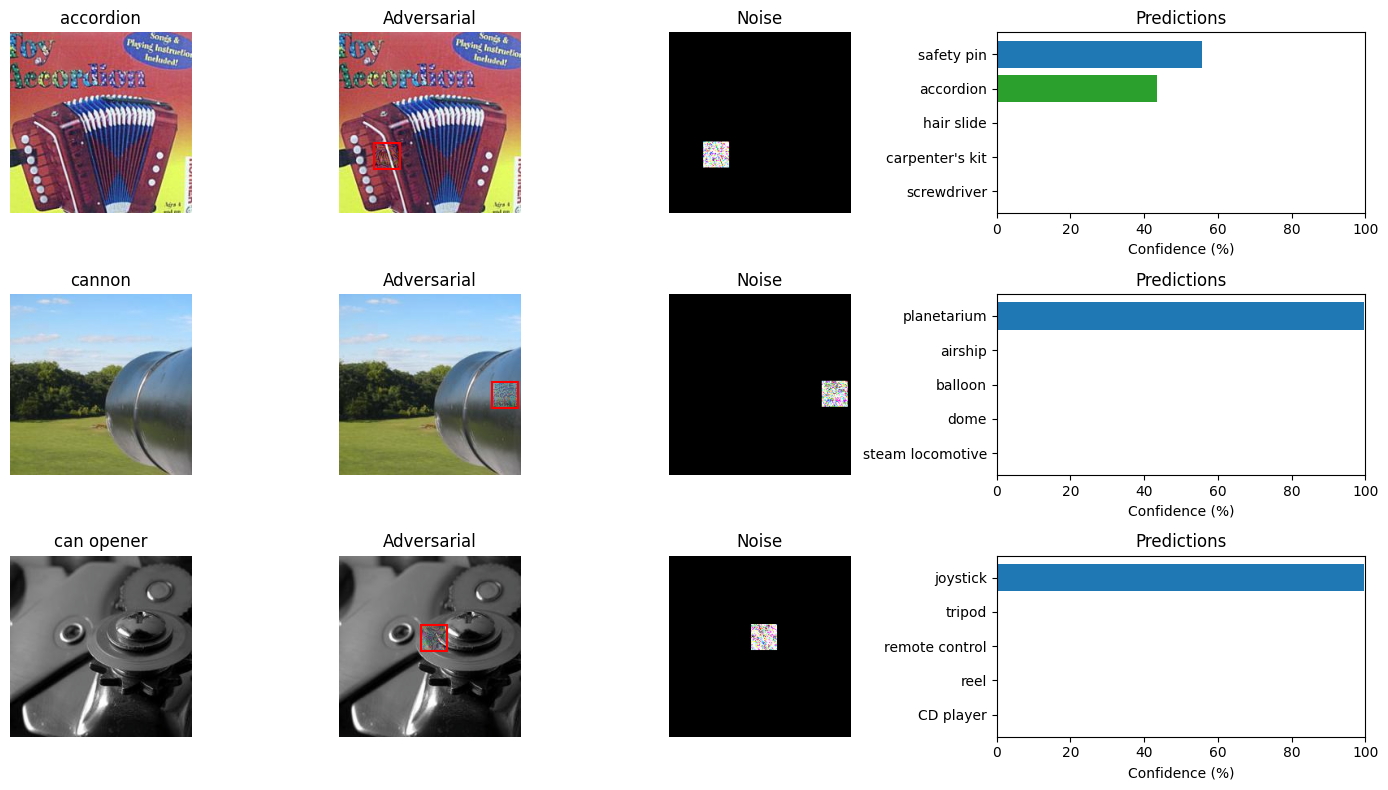

In [9]:
import torch, numpy as np, matplotlib.pyplot as plt, random
from matplotlib.patches import Rectangle

def plot_three_patchpgd_examples(model,
                                 dataset,
                                 eps        = 0.5,
                                 alpha      = 0.08,
                                 steps      = 60,
                                 mu         = 0.5,
                                 restarts   = 3,
                                 patch_size = 32,
                                 k          = 5,
                                 idx_list   = None):

    model_dev = next(model.parameters()).device
    model.eval()

    if idx_list is None:
        idx_list = random.sample(range(len(dataset)), 3)

    clean_t, adv_t, coords_list, gtlbls, probs_list = [], [], [], [], []

    for idx in idx_list:
        img, lbl = dataset[idx]
        img_t  = img.unsqueeze(0).to(model_dev)
        lbl_t  = torch.tensor([lbl]).to(model_dev)

        adv_img, coords = patch_pgd_momentum(img_t.clone(), lbl_t, model,
                                             eps=eps, alpha=alpha, steps=steps,
                                             mu=mu, restarts=restarts,
                                             patch_size=patch_size)

        with torch.no_grad():
            probs = torch.softmax(model(adv_img), dim=-1)[0].cpu()

        clean_t.append(img_t[0].detach())
        adv_t.append(adv_img[0].detach())
        coords_list.append(coords[0])
        gtlbls.append(lbl)
        probs_list.append(probs)

    fig, axes = plt.subplots(3, 4, figsize=(14, 8),
                             gridspec_kw={'width_ratios': [1, 1, 1, 2]})

    for row in range(3):
        clean_disp = unnormalize(clean_t[row])
        adv_disp   = unnormalize(adv_t[row])
        noise_disp = np.abs(adv_disp - clean_disp)
        if noise_disp.max() > 0:
            noise_disp /= noise_disp.max()

        gt = gtlbls[row]
        top_vals, top_idx = probs_list[row].topk(k)
        top_vals = (top_vals.numpy() * 100)
        top_idx  = top_idx.numpy()

        titles = [full_label_names.get(gt, str(gt)),
                  'Adversarial', 'Noise']
        for col, im, ttl in zip(range(3),
                                [clean_disp, adv_disp, noise_disp],
                                titles):
            ax = axes[row, col]
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(ttl, fontsize=12)

        t, l = coords_list[row]
        patch = Rectangle((l, t), patch_size, patch_size,
                          linewidth=1.5, edgecolor='red', facecolor='none')
        axes[row, 1].add_patch(patch)
        ax = axes[row, 3]
        colors = ['C2' if top_idx[i] == gt else 'C0' for i in range(k)]
        ax.barh(np.arange(k), top_vals, color=colors)
        ax.set_yticks(np.arange(k))
        ax.set_yticklabels([full_label_names.get(i, str(i)) for i in top_idx])
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        ax.set_xlabel('Confidence (%)')
        ax.set_title('Predictions', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_three_patchpgd_examples(model, test_dataset)